* Bilgisayar mühendisliği binası önünden farklı konum ve açılardan ve benzer içerik barındıran iki görüntü yakalayınız. 
    - Görüntüleri ucak1.jpg ve ucak2.jpg şeklinde kaydediniz. Karmaşayı azaltmak için görüntünün boyutunu öncesinde uygun ölçüde küçültebilirsiniz.  

  
* Ardından ucak1.jpg  görüntüsünü  ucak2.jpg  görüntüsüne  çeviren  homografi  matrisinin  parametrelerini RANSAC algoritması ile bulunuz.  
    - Bunun  için  ucak1.jpg  ve  ucak2.jpg  görüntüleri  üzerinde hazır  SIFT,    SURF veya  ORBS  algoritmasını  çalıştırarak  nokta  eşlemelerini  belirleyiniz. 

* Belirlediğiniz nokta eşlemeleri ile her seferinde rastgele 20 eşlenmiş nokta  çifti  seçerek  100 tekrarla  RANSAC  algoritmasını  çalıştırınız.  

* Nihayette en yüksek sayıda uyumlu noktayı içeren homografi matrisini belirtiniz. Bu homografinin uyumlu noktalarını ve aykırı noktalarını ucak1.jpg ve ucak2.jpg görüntüleri üzerine çizdirerek gösteriniz. 

* ucak1.jpg görüntüsünü bulduğunuz bu homografi matrisi ile eğme (warping) işlemini çift doğrusal ara değerleme (bilinear interpolation) kullanarak gerçekleştiriniz. 

* Eğilmiş ucak1.jpg ile ucak2.jpg görüntülerini daha büyük bir görüntü düzleminde  harmanlayınız  (blending). 

-- Not:  
    images/campus klasörü altındaki P1070507.jpg ve P1070509.jpg görüntülerini ucak1.jpg ve 
ucak2.jpg yerine de kullanabilirsiniz.

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

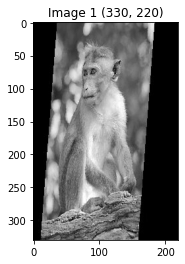

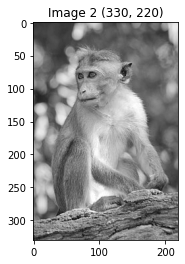

In [2]:
img1 = cv2.imread('data/monkey_distorted.jpg')          # Image that needs to be registered.
img2 = cv2.imread('data/monkey.jpg') # trainImage

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

plt.imshow(img1, cmap='gray')
plt.title(f'Image 1 {img1.shape}')
plt.show()

plt.imshow(img2, cmap='gray')
plt.title(f'Image 2 {img2.shape}')
plt.show()

In [3]:
def createPointMap(image1, image2, verbose=True, merge_keypoints=True):
    """
    Creates a point map of shape (n, 4) where n is the number of matches
    between the two images. Each row contains (x1, y1, x2, y2), where (x1, y1)
    in image1 maps to (x2, y2) in image2.
    sift.detectAndCompute returns
        keypoints: a list of keypoints
        descriptors: a numpy array of shape (num keypoints, 128)
    """
    if verbose: print('Finding keypoints and descriptors for both images...')
    sift = cv2.SIFT_create()
    kp1, desc1 = sift.detectAndCompute(image1, None)
    kp2, desc2 = sift.detectAndCompute(image2, None)

    if verbose: print('Determining matches...')
    matches = cv2.BFMatcher(cv2.NORM_L2, True).match(desc1, desc2)

    
    if not merge_keypoints:
        point_map = np.array([
            [
            kp1[match.queryIdx].pt,
            kp2[match.trainIdx].pt] for match in matches
        ])
    else:
        point_map = np.array([
            [kp1[match.queryIdx].pt[0],
            kp1[match.queryIdx].pt[1],
            kp2[match.trainIdx].pt[0],
            kp2[match.trainIdx].pt[1]] for match in matches
        ])
    
    return point_map

In [4]:
def drawMatches(image1, image2, point_map, inliers=None, max_points=100):
    """
    inliers: set of (x1, y1) points
    """
    # Blue if inliers==None, Green if inliers, red if outliers

    BLUE = (255, 0, 0)
    GREEN = (0, 255, 0)
    RED = (0, 0, 255)
    
    rows1, cols1 = image1.shape[0], image1.shape[1]
    rows2, cols2 = image2.shape[0], image2.shape[1]

    matchImage = np.zeros((max(rows1, rows2), cols1 + cols2, 3), dtype='uint8')
    matchImage[:rows1, :cols1, :] = np.dstack([image1] * 3)
    matchImage[:rows2, cols1:cols1 + cols2, :] = np.dstack([image2] * 3)

    small_point_map = [point_map[i] for i in np.random.choice(len(point_map), max_points)]

    # draw lines
    for x1, y1, x2, y2 in small_point_map:
        point1 = (int(x1), int(y1))
        point2 = (int(x2 + image1.shape[1]), int(y2))
        color = BLUE if inliers is None else (
            GREEN if (x1, y1, x2, y2) in inliers else RED)

        cv2.line(matchImage, point1, point2, color, 1)

    # Draw circles on top of the lines
    for x1, y1, x2, y2 in small_point_map:
        point1 = (int(x1), int(y1))
        point2 = (int(x2 + image1.shape[1]), int(y2))
        cv2.circle(matchImage, point1, 5, BLUE, 1)
        cv2.circle(matchImage, point2, 5, BLUE, 1)

    return matchImage

In [5]:
def computeHomography(pairs):
    """
    Solves for the homography given any number of pairs of points. 
    
    Visit http://6.869.csail.mit.edu/fa12/lectures/lecture13ransac/lecture13ransac.pdf
    slide 9 for more details.
    """
    A = []
    for x1, y1, x2, y2 in pairs:
        A.append([x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 * y1, -x1])
        A.append([0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y1])
    A = np.array(A)

    # Singular Value Decomposition (SVD)
    U, S, V = np.linalg.svd(A)

    # V has shape (9, 9) for any number of input pairs. V[-1] is the eigenvector
    # of (A^T)A with the smalles eigenvalue. Reshape into 3x3 matrix.
    H = np.reshape(V[-1], (3, 3))

    # Normalization
    H = (1 / H.item(8)) * H
    return H

In [9]:
def dist(pair, H):
    """ 
    Returns the geometric distance between a pair of points given the
    homography H. 
    """
    # points in homogeneous coordinates
    p1 = np.array([pair[0], pair[1], 1])
    p2 = np.array([pair[2], pair[3], 1])

    p2_estimate = np.dot(H, np.transpose(p1))
    p2_estimate = (1 / p2_estimate[2]) * p2_estimate
    
    return np.linalg.norm(np.transpose(p2) - p2_estimate)

def RANSAC(point_map, n=4, threshold=0.8, num_iters=100, verbose=True):
    if verbose: print(f'Running RANSAC with {len(point_map)} points...')
    bestInliers = set()
    homography = None
    for i in range(num_iters):
        # randomly choose n points from the matrix to compute the homography
        pairs = [point_map[i] for i in np.random.choice(len(point_map), n)]

        H = computeHomography(pairs)
        inliers = {(c[0], c[1], c[2], c[3]) for c in point_map if dist(c, H) < 50}
        
        if verbose:
            print(f'\x1b[2K\r└──> iteration {i + 1}/{num_iters} ' + \
                  f'\t{len(inliers)} inlier' + ('s ' if len(inliers) != 1 else ' ') + \
                  f'\tbest: {len(bestInliers)}', end='')

        if len(inliers) > len(bestInliers):
            bestInliers = inliers
            homography = H
            if len(bestInliers) > (len(point_map) * threshold): break

    if verbose:
        print(f'\nNum matches: {len(point_map)}')
        print(f'Num inliers: {len(bestInliers)}')
        print(f'Min inliers: {len(point_map) * threshold}')

    return homography, bestInliers

Finding keypoints and descriptors for both images...
Determining matches...
Running RANSAC with 171 points...
└──> iteration 1/100 	120 inliers 	best: 0
Num matches: 171
Num inliers: 120
Min inliers: 34.2

Estimated homography : 
 [[ 1.00000000e+00 -2.90697875e-16  1.40689579e-13]
 [-4.05225889e-16  1.00000000e+00  6.36936276e-15]
 [-3.00462920e-18  0.00000000e+00  1.00000000e+00]]


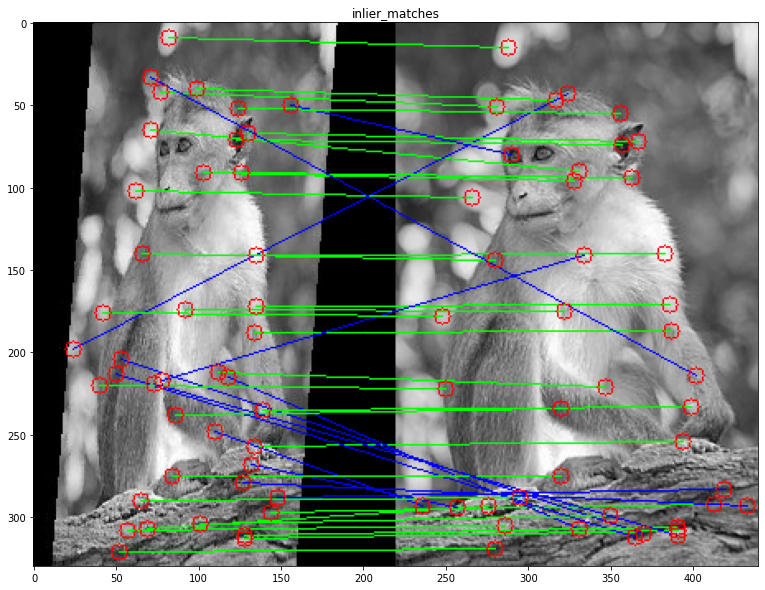

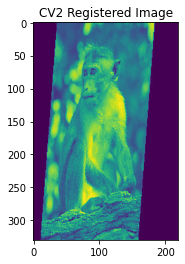

In [12]:
point_map = createPointMap(img1, img2, merge_keypoints=True)
homography, inliers = RANSAC(point_map, n=20, threshold=0.2, num_iters=100, verbose=True)

print("\nEstimated homography : \n",  homography)

plt.figure(figsize=(20, 10))
plt.imshow(drawMatches(img1, img2, point_map, inliers, max_points=50))
plt.title('inlier_matches')
plt.show()

height, width = img2.shape
im1Reg = cv2.warpPerspective(img1, homography, (width, height))

plt.imshow(im1Reg)
plt.title('CV2 Registered Image')
plt.show()

## apply the same operation in cv2 to verify implementation

Finding keypoints and descriptors for both images...
Determining matches...
Estimated homography : 
 [[ 1.49058861e+00  1.14757656e-01 -5.54998386e+01]
 [-3.78531317e-02  9.66233687e-01  1.06546385e+01]
 [-1.23711039e-05  6.26199508e-06  1.00000000e+00]]


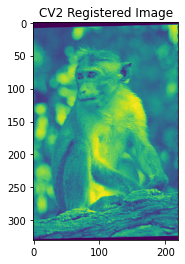

In [8]:
def cv2_homography(img1, img2):
    
    point_map = createPointMap(img1, img2, merge_keypoints=False)
    
    h, mask = cv2.findHomography(point_map[:, 0], point_map[:, 1], cv2.RANSAC)
    print("Estimated homography : \n",  h)

    height, width = img2.shape
    im1Reg = cv2.warpPerspective(img1, h, (width, height))

    plt.imshow(im1Reg)
    plt.title('CV2 Registered Image')
    plt.show()

    return im1Reg

im1Reg = cv2_homography(img1, img2)